In [91]:
import os
import glob
import pickle

import pandas as pd
import ydata_profiling
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from library.sb_utils import save_file

## Electric usage data

**PG&E Electric Usage by Zipcode**

Info on this dataset from PG&E (https://pge-energydatarequest.com/public_datasets/download?type=electric):

Customer usage data, both for gas (therms) and electric (kWh) usage, is reported by ZIP code, by month, by year, and by the four customer types – residential, commercial, agricultural and industrial. The reports on this data are made available pursuant to California Public Utilities Commission Decision 14-05-016 (view the Decision here). Accordingly, the public datasets meet Commission Decision rules for public aggregation of data, as follows: a minimum of 100 Residential customers; a minimum of 15 Non-Residential customers, with no single Non-Residential customer accounting for more than 15% of the total consumption. If aggregation is not met, the consumption will be combined with a neighboring ZIP code until the aggregation requirements are met.

Let's examine one file:

In [92]:
df = pd.read_csv('data/PGE_ElectricUsageByZip/PGE_2013_Q1_ElectricUsageByZip.csv')

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7521 entries, 0 to 7520
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ZipCode         7521 non-null   int64 
 1   Month           7521 non-null   int64 
 2   Year            7521 non-null   int64 
 3   CustomerClass   7521 non-null   object
 4   Combined        7521 non-null   object
 5   TotalCustomers  7521 non-null   object
 6   TotalkWh        7521 non-null   object
 7   AveragekWh      3172 non-null   object
dtypes: int64(3), object(5)
memory usage: 470.2+ KB


In [94]:
df.head()

ZipCode  Month  Year       CustomerClass Combined TotalCustomers TotalkWh  \
0    93202      1  2013  Elec- Agricultural        Y              0        0   
1    93202      2  2013  Elec- Agricultural        Y              0        0   
2    93202      3  2013  Elec- Agricultural        Y              0        0   
3    93203      1  2013  Elec- Agricultural        Y              0        0   
4    93203      2  2013  Elec- Agricultural        Y              0        0   

  AveragekWh  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN

The data comes in quarterly files. We need to concatenate them into a single DataFrame.

Column naming is inconsistent between quarterly files. Some have all uppercase column names, some have mixed case. Need to correct this by renaming columns.

In [95]:
electric_usage = pd.DataFrame()

files = glob.glob('data/PGE_ElectricUsageByZip/*.csv')

colmap = dict(zip(list(df.columns.str.upper()), list(df.columns)))

for file in files:
    df = pd.read_csv(file)
    # column names change case partway through the dataset
    df.rename(columns=colmap, inplace=True)
    electric_usage = pd.concat([electric_usage, df], ignore_index=True)

In [96]:
electric_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349895 entries, 0 to 349894
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ZipCode         349895 non-null  int64 
 1   Month           349895 non-null  int64 
 2   Year            349895 non-null  int64 
 3   CustomerClass   349895 non-null  object
 4   Combined        349895 non-null  object
 5   TotalCustomers  349895 non-null  object
 6   TotalkWh        349895 non-null  object
 7   AveragekWh      158522 non-null  object
dtypes: int64(3), object(5)
memory usage: 21.4+ MB


In [97]:
electric_usage.head()

ZipCode  Month  Year       CustomerClass Combined TotalCustomers TotalkWh  \
0    93101      7  2021  Elec- Agricultural        Y              0        0   
1    93101      8  2021  Elec- Agricultural        Y              0        0   
2    93101      9  2021  Elec- Agricultural        Y              0        0   
3    93110      7  2021  Elec- Agricultural        Y              0        0   
4    93110      8  2021  Elec- Agricultural        Y              0        0   

  AveragekWh  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN

In [98]:
# cast columns as appropriate data types

electric_usage['CustomerClass'] = electric_usage['CustomerClass'].astype('category')
electric_usage['Combined'] = electric_usage['Combined'].astype('category')

electric_usage['TotalCustomers'] = pd.to_numeric(electric_usage['TotalCustomers'].str.replace(',',''))
electric_usage['TotalkWh'] = pd.to_numeric(electric_usage['TotalkWh'].str.replace(',',''))
electric_usage['AveragekWh'] = pd.to_numeric(electric_usage['AveragekWh'].str.replace(',',''))



Let's create more useful date columns:

In [99]:
electric_usage['Day'] = 1
electric_usage['Date'] = pd.to_datetime(electric_usage[['Year', 'Month', 'Day']])
electric_usage['DateMY'] = electric_usage['Date'].dt.strftime('%Y-%m')

In [100]:
electric_usage.head()

ZipCode  Month  Year       CustomerClass Combined  TotalCustomers  \
0    93101      7  2021  Elec- Agricultural        Y               0   
1    93101      8  2021  Elec- Agricultural        Y               0   
2    93101      9  2021  Elec- Agricultural        Y               0   
3    93110      7  2021  Elec- Agricultural        Y               0   
4    93110      8  2021  Elec- Agricultural        Y               0   

   TotalkWh  AveragekWh  Day       Date   DateMY  
0         0         NaN    1 2021-07-01  2021-07  
1         0         NaN    1 2021-08-01  2021-08  
2         0         NaN    1 2021-09-01  2021-09  
3         0         NaN    1 2021-07-01  2021-07  
4         0         NaN    1 2021-08-01  2021-08

In [101]:
electric_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349895 entries, 0 to 349894
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   ZipCode         349895 non-null  int64         
 1   Month           349895 non-null  int64         
 2   Year            349895 non-null  int64         
 3   CustomerClass   349895 non-null  category      
 4   Combined        349895 non-null  category      
 5   TotalCustomers  349895 non-null  int64         
 6   TotalkWh        349895 non-null  int64         
 7   AveragekWh      158522 non-null  float64       
 8   Day             349895 non-null  int64         
 9   Date            349895 non-null  datetime64[ns]
 10  DateMY          349895 non-null  object        
dtypes: category(2), datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 24.7+ MB


Let's look for duplicates:

In [102]:
# Explore duplicates
duplicates = electric_usage.duplicated()
sum(duplicates)

14863

There are many duplicates. Some quarterly data files cover more than one quarter of data. Drop the duplicates:

In [103]:
electric_usage.drop_duplicates(inplace=True)

Next, we generate a profile report using ydata_profiling to examine counts, ranges, uniques, and missing values for each variable in our category of choice, residential customers.

In [104]:
report_residential = electric_usage.loc[electric_usage['CustomerClass'] == 'Elec- Residential'].profile_report(sort=None, html={'style':{'full_width': True}}, progress_bar=False)
# report_residential.to_widgets() # run this to convert the report to a widget
report_residential

We see above that 8.8% of our target values (AveragekWh) are missing. This could be due to zip codes that are primarily commercial, industrial, or agricultural, and therefore do not have any residential customers. Let's downselect to only residential customers, then remove all zip codes that have missing data:

In [105]:
electric_res = electric_usage.loc[electric_usage['CustomerClass'] == 'Elec- Residential']
zips_to_drop = electric_res['ZipCode'].loc[electric_res['AveragekWh'].isnull()].unique()
electric_res = electric_res[~electric_res['ZipCode'].isin(zips_to_drop)]


In [106]:
len(electric_res['ZipCode'].unique())

727

We went from 876 unique zip codes to 727, dropping 149 zip codes with missing usage data.

In [107]:
electric_res.reset_index(drop=True, inplace=True)

In [108]:
electric_res.head()

ZipCode  Month  Year      CustomerClass Combined  TotalCustomers  TotalkWh  \
0    93201      7  2021  Elec- Residential        N             314    390705   
1    93201      8  2021  Elec- Residential        N             313    342974   
2    93201      9  2021  Elec- Residential        N             315    266662   
3    93203      7  2021  Elec- Residential        Y            5042   6399477   
4    93203      8  2021  Elec- Residential        Y            5048   5741307   

   AveragekWh  Day       Date   DateMY  
0      1244.0    1 2021-07-01  2021-07  
1      1096.0    1 2021-08-01  2021-08  
2       847.0    1 2021-09-01  2021-09  
3      1269.0    1 2021-07-01  2021-07  
4      1137.0    1 2021-08-01  2021-08

In [109]:
# final wrangled electric data
electric_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97299 entries, 0 to 97298
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ZipCode         97299 non-null  int64         
 1   Month           97299 non-null  int64         
 2   Year            97299 non-null  int64         
 3   CustomerClass   97299 non-null  category      
 4   Combined        97299 non-null  category      
 5   TotalCustomers  97299 non-null  int64         
 6   TotalkWh        97299 non-null  int64         
 7   AveragekWh      97299 non-null  float64       
 8   Day             97299 non-null  int64         
 9   Date            97299 non-null  datetime64[ns]
 10  DateMY          97299 non-null  object        
dtypes: category(2), datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 6.9+ MB


Let's look at average usage over time for all zip codes, and for two specific zip codes:

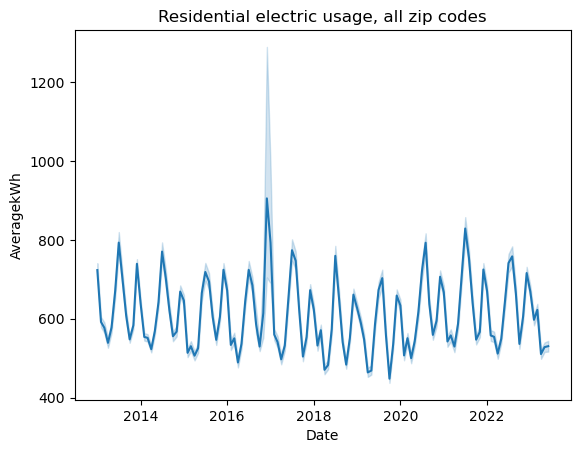

In [110]:
sns.lineplot(data=electric_res, x='Date', y='AveragekWh')
plt.title('Residential electric usage, all zip codes')
plt.show()

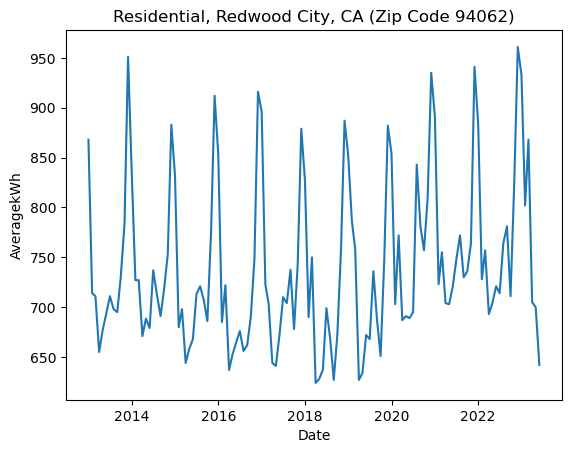

In [111]:
sns.lineplot(data=electric_res.loc[electric_res['ZipCode'] == 94062], x='Date', y='AveragekWh')
plt.title('Residential, Redwood City, CA (Zip Code 94062)')

plt.show()

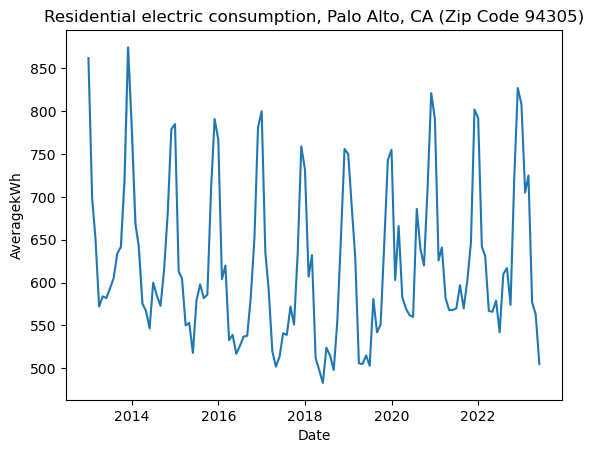

In [112]:
sns.lineplot(data=electric_res.loc[electric_res['ZipCode'] == 94305], x='Date', y='AveragekWh')
plt.title('Residential electric consumption, Palo Alto, CA (Zip Code 94305)')

plt.show()

The individual zip code data looks clean. The all zip codes plot shows an anomalous spike in usage around 2017. We will examine this more in EDA.

In [83]:
# store and save the data

%store electric_res

datapath = './data'
save_file(electric_res, 'electric_res.csv', datapath)

Stored 'electric_res' (DataFrame)
Writing file.  "./data/electric_res.csv"


Pickle all Residential electrical data

In [84]:
filename = './data/electric_res.pkl'

electric_res = electric_usage.loc[
        electric_usage['CustomerClass'] == 'Elec- Residential']

with open(filename, 'wb') as f:
    pickle.dump(electric_res, f)

## Weather data - Bulk file

NCEI Climate Data bulk downloads - https://www.ncei.noaa.gov/pub/data/ghcn/daily/

Data reference docs: 

./data/readme.txt

./data/readme_by_station.txt

./data/ghcnd-stations.txt

Station of interest:

Redwood City, CA, 94062 station ID: USC00047339

Temperature format: integer, in 0.1 degrees C

In [52]:
columns = ['ID', 'DATE', 'ELEMENT', 'DATA VALUE', 'M-FLAG', 'Q-FLAG', 'S-FLAG', 'OBS-TIME']
df_w = pd.read_csv('data/GHCN/USC00047339.csv', names=columns, parse_dates=[1])

/var/folders/v5/lm06n0rd7719lt2t23hxfg600000gn/T/ipykernel_7179/536635528.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_w = pd.read_csv('data/GHCN/USC00047339.csv', names=columns, parse_dates=[1])


In [53]:
df_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171334 entries, 0 to 171333
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   ID          171334 non-null  object        
 1   DATE        171334 non-null  datetime64[ns]
 2   ELEMENT     171334 non-null  object        
 3   DATA VALUE  171334 non-null  int64         
 4   M-FLAG      33321 non-null   object        
 5   Q-FLAG      519 non-null     object        
 6   S-FLAG      171334 non-null  object        
 7   OBS-TIME    121778 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 10.5+ MB


In [54]:
df_w.head()

ID       DATE ELEMENT  DATA VALUE M-FLAG Q-FLAG S-FLAG  OBS-TIME
0  USC00047339 1906-04-01    PRCP          38    NaN    NaN      6       NaN
1  USC00047339 1906-04-02    PRCP          15    NaN    NaN      6       NaN
2  USC00047339 1906-04-03    PRCP           0      P    NaN      6       NaN
3  USC00047339 1906-04-04    PRCP           0      P    NaN      6       NaN
4  USC00047339 1906-04-05    PRCP           0      P    NaN      6       NaN

In [55]:
df_weather = df_w.pivot(columns='ELEMENT', index='DATE', values=['DATA VALUE'])
df_weather.head()

DATA VALUE                                                          \
ELEMENT          DAPR MDPR  PRCP SNOW SNWD TMAX TMIN TOBS WT01 WT03 WT05 WT11   
DATE                                                                            
1906-04-01        NaN  NaN  38.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1906-04-02        NaN  NaN  15.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1906-04-03        NaN  NaN   0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1906-04-04        NaN  NaN   0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1906-04-05        NaN  NaN   0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                      
ELEMENT    WT14 WT16  
DATE                  
1906-04-01  NaN  1.0  
1906-04-02  NaN  NaN  
1906-04-03  NaN  NaN  
1906-04-04  NaN  NaN  
1906-04-05  NaN  NaN

In [56]:
df_weather.columns

MultiIndex([('DATA VALUE', 'DAPR'),
            ('DATA VALUE', 'MDPR'),
            ('DATA VALUE', 'PRCP'),
            ('DATA VALUE', 'SNOW'),
            ('DATA VALUE', 'SNWD'),
            ('DATA VALUE', 'TMAX'),
            ('DATA VALUE', 'TMIN'),
            ('DATA VALUE', 'TOBS'),
            ('DATA VALUE', 'WT01'),
            ('DATA VALUE', 'WT03'),
            ('DATA VALUE', 'WT05'),
            ('DATA VALUE', 'WT11'),
            ('DATA VALUE', 'WT14'),
            ('DATA VALUE', 'WT16')],
           names=[None, 'ELEMENT'])

In [57]:
column_names =  [x[1] for x in df_weather.columns]

In [58]:
df_weather.columns = column_names

In [59]:
df_weather.head()

DAPR  MDPR  PRCP  SNOW  SNWD  TMAX  TMIN  TOBS  WT01  WT03  WT05  \
DATE                                                                           
1906-04-01   NaN   NaN  38.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1906-04-02   NaN   NaN  15.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1906-04-03   NaN   NaN   0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1906-04-04   NaN   NaN   0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1906-04-05   NaN   NaN   0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

            WT11  WT14  WT16  
DATE                          
1906-04-01   NaN   NaN   1.0  
1906-04-02   NaN   NaN   NaN  
1906-04-03   NaN   NaN   NaN  
1906-04-04   NaN   NaN   NaN  
1906-04-05   NaN   NaN   NaN

In [60]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35303 entries, 1906-04-01 to 2023-05-12
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DAPR    4 non-null      float64
 1   MDPR    13 non-null     float64
 2   PRCP    34686 non-null  float64
 3   SNOW    24567 non-null  float64
 4   SNWD    22138 non-null  float64
 5   TMAX    32873 non-null  float64
 6   TMIN    32905 non-null  float64
 7   TOBS    23600 non-null  float64
 8   WT01    275 non-null    float64
 9   WT03    50 non-null     float64
 10  WT05    35 non-null     float64
 11  WT11    45 non-null     float64
 12  WT14    7 non-null      float64
 13  WT16    136 non-null    float64
dtypes: float64(14)
memory usage: 4.0 MB


In [73]:
report_weather = df_weather.profile_report(sort=None, html={'style':{'full_width': True}}, progress_bar=False)
report_weather

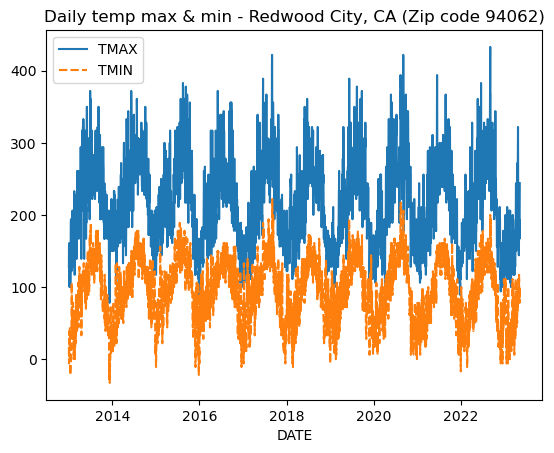

In [88]:
sns.lineplot(data=df_weather['2013-01-01':][['TMAX', 'TMIN']])
plt.title('Daily temp max & min - Redwood City, CA (Zip code 94062)')
plt.show()

In [63]:
df_weather['2013-01-01':'2013-02-05'].head()

DAPR  MDPR  PRCP  SNOW  SNWD   TMAX  TMIN  TOBS  WT01  WT03  WT05  \
DATE                                                                            
2013-01-01   NaN   NaN   0.0   NaN   NaN  128.0  17.0  17.0   NaN   NaN   NaN   
2013-01-02   NaN   NaN   0.0   NaN   NaN  156.0  -6.0  28.0   NaN   NaN   NaN   
2013-01-03   NaN   NaN   0.0   NaN   NaN  144.0   0.0  39.0   NaN   NaN   NaN   
2013-01-04   NaN   NaN   0.0   NaN   NaN  161.0  17.0  39.0   NaN   NaN   NaN   
2013-01-05   NaN   NaN  10.0   NaN   NaN  122.0  22.0  94.0   NaN   NaN   NaN   

            WT11  WT14  WT16  
DATE                          
2013-01-01   NaN   NaN   NaN  
2013-01-02   NaN   NaN   NaN  
2013-01-03   NaN   NaN   NaN  
2013-01-04   NaN   NaN   NaN  
2013-01-05   NaN   NaN   NaN

In [76]:
df_TMAX = df_weather['2013-01-01':][['TMAX']]

In [73]:
df_weather['2013-01-01':][['TMAX']].isnull().sum()

TMAX    4
dtype: int64

In [79]:
df_TMAX[df_TMAX['TMAX'].isnull()]

TMAX
DATE            
2013-10-18   NaN
2013-12-04   NaN
2013-12-10   NaN
2014-02-11   NaN

In [82]:
df_TMAX.interpolate(inplace=True)

In [83]:
df_TMAX[df_TMAX['TMAX'].isnull()]

Empty DataFrame
Columns: [TMAX]
Index: []

<Figure size 640x480 with 0 Axes>

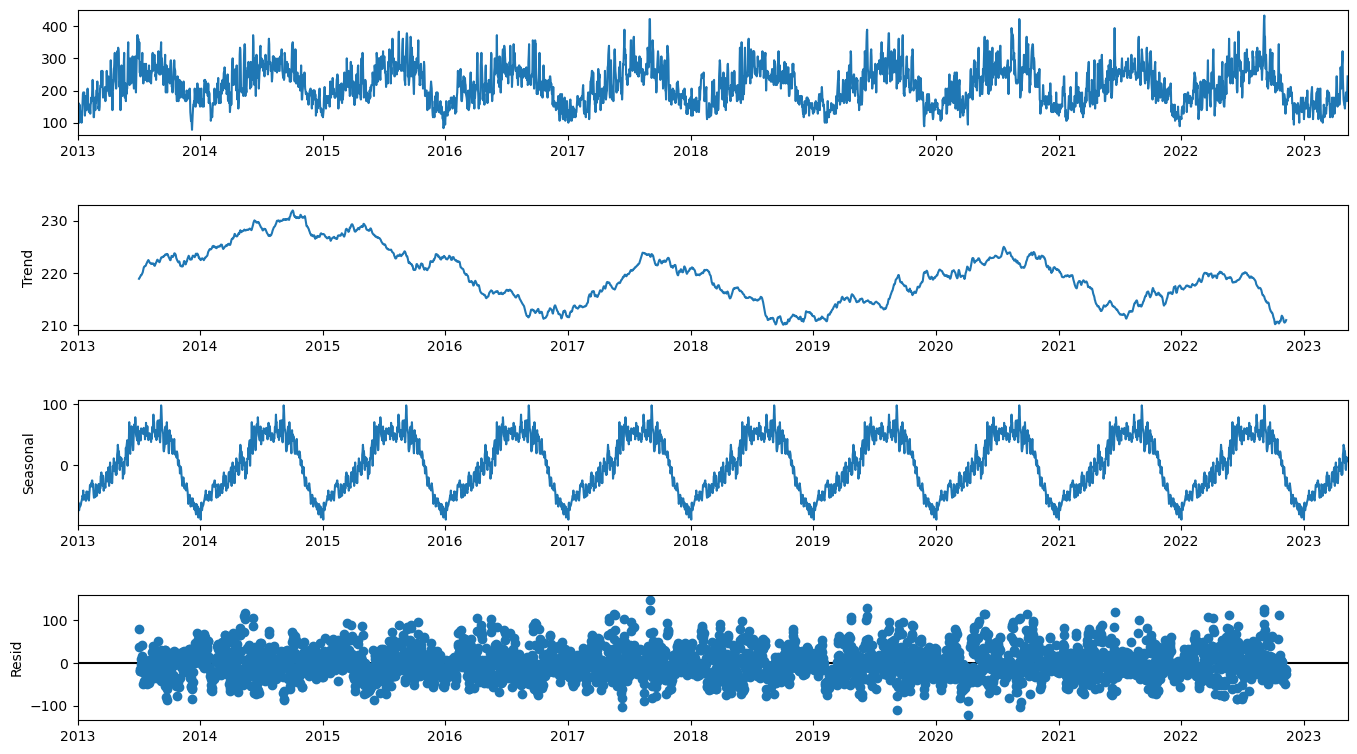

In [87]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_TMAX, period=365)
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

## Weather data - API

NOAA Climate Data Online API

API reference: https://www.ncdc.noaa.gov/cdo-web/webservices/v2#gettingStarted

Rate limits:
- 5 requests/sec
- 10,000 requests/day

Limit on records per request: 1000, default is 25
Use 'limit' parameter to set max requests returned.
Use 'offset' parameter to offset the resultlist

In [134]:
import requests

urlbase = "https://www.ncei.noaa.gov/cdo-web/api/v2/"
API_KEY = 'DkPICwzoALejycYunGIMWgAOofUCZMNr'
headers = {'token':API_KEY}

In [138]:
# Fetch all available datasets
dataset = 'datasets'
params = {}
r = requests.get(urlbase + dataset, headers=headers, params=params)
r.json()

In [139]:
r.json()

{'metadata': {'resultset': {'offset': 1, 'count': 11, 'limit': 25}},
 'results': [{'uid': 'gov.noaa.ncdc:C00861',
   'mindate': '1763-01-01',
   'maxdate': '2023-04-13',
   'name': 'Daily Summaries',
   'datacoverage': 1,
   'id': 'GHCND'},
  {'uid': 'gov.noaa.ncdc:C00946',
   'mindate': '1763-01-01',
   'maxdate': '2023-03-01',
   'name': 'Global Summary of the Month',
   'datacoverage': 1,
   'id': 'GSOM'},
  {'uid': 'gov.noaa.ncdc:C00947',
   'mindate': '1763-01-01',
   'maxdate': '2023-01-01',
   'name': 'Global Summary of the Year',
   'datacoverage': 1,
   'id': 'GSOY'},
  {'uid': 'gov.noaa.ncdc:C00345',
   'mindate': '1991-06-05',
   'maxdate': '2023-04-13',
   'name': 'Weather Radar (Level II)',
   'datacoverage': 0.95,
   'id': 'NEXRAD2'},
  {'uid': 'gov.noaa.ncdc:C00708',
   'mindate': '1994-05-20',
   'maxdate': '2023-04-15',
   'name': 'Weather Radar (Level III)',
   'datacoverage': 0.95,
   'id': 'NEXRAD3'},
  {'uid': 'gov.noaa.ncdc:C00821',
   'mindate': '2010-01-01',
   

In [150]:
# Fetch all info about Daily Summary dataset
dataset = 'datasets/GHCND'
params = {}
r = requests.get(urlbase + dataset, headers=headers, params=params)
r.json()

{'mindate': '1763-01-01',
 'maxdate': '2023-04-13',
 'name': 'Daily Summaries',
 'datacoverage': 1,
 'id': 'GHCND'}

In [259]:
# Fetch all available data types
# Note: there are 
dataset = 'datatypes'
params = {'limit':'1000'}
r = requests.get(urlbase + dataset, headers=headers, params=params)
r.json()

{'metadata': {'resultset': {'offset': 1, 'count': 1566, 'limit': 1000}},
 'results': [{'mindate': '1994-03-19',
   'maxdate': '1996-05-28',
   'name': 'Average cloudiness midnight to midnight from 30-second ceilometer data',
   'datacoverage': 1,
   'id': 'ACMC'},
  {'mindate': '1965-01-01',
   'maxdate': '2005-12-31',
   'name': 'Average cloudiness midnight to midnight from manual observations',
   'datacoverage': 1,
   'id': 'ACMH'},
  {'mindate': '1994-02-01',
   'maxdate': '1996-05-28',
   'name': 'Average cloudiness sunrise to sunset from 30-second ceilometer data',
   'datacoverage': 1,
   'id': 'ACSC'},
  {'mindate': '1965-01-01',
   'maxdate': '2005-12-31',
   'name': 'Average cloudiness sunrise to sunset from manual observations',
   'datacoverage': 1,
   'id': 'ACSH'},
  {'mindate': '1991-06-05',
   'maxdate': '2023-04-13',
   'name': 'Base Data',
   'datacoverage': 0.95,
   'id': 'ALL'},
  {'mindate': '2010-01-01',
   'maxdate': '2010-01-01',
   'name': 'Long-term averages o

In [260]:
dataset = 'datatypes'
params = {'limit':'1000', 'offset':'1001'}
r2 = requests.get(urlbase + dataset, headers=headers, params=params)
r2.json()

{'metadata': {'resultset': {'offset': 1001, 'count': 1566, 'limit': 1000}},
 'results': [{'mindate': '2010-01-01',
   'maxdate': '2010-12-01',
   'name': 'Long-term averages of monthly growing degree days with base 50F',
   'datacoverage': 1,
   'id': 'MLY-GRDD-BASE50'},
  {'mindate': '2010-01-01',
   'maxdate': '2010-12-01',
   'name': 'Long-term averages of monthly growing degree days with base 55F',
   'datacoverage': 1,
   'id': 'MLY-GRDD-BASE55'},
  {'mindate': '2010-01-01',
   'maxdate': '2010-12-01',
   'name': 'Long-term averages of monthly growing degree days with base 57F',
   'datacoverage': 1,
   'id': 'MLY-GRDD-BASE57'},
  {'mindate': '2010-01-01',
   'maxdate': '2010-12-01',
   'name': 'Long-term averages of monthly growing degree days with base 60F',
   'datacoverage': 1,
   'id': 'MLY-GRDD-BASE60'},
  {'mindate': '2010-01-01',
   'maxdate': '2010-12-01',
   'name': 'Long-term averages of monthly growing degree days with base 65F',
   'datacoverage': 1,
   'id': 'MLY-GRD

In [261]:
weather_dtypes = pd.concat([pd.DataFrame(r.json()['results']), pd.DataFrame(r2.json()['results'])])
weather_dtypes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1566 entries, 0 to 565
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mindate       1566 non-null   object 
 1   maxdate       1566 non-null   object 
 2   name          1566 non-null   object 
 3   datacoverage  1561 non-null   float64
 4   id            1566 non-null   object 
dtypes: float64(1), object(4)
memory usage: 73.4+ KB


In [205]:
# Fetch info on TMAX datatype
# Note: there are 
dataset = 'datatypes/TMAX'
params = {'limit':'1000'}
r = requests.get(urlbase + dataset, headers=headers, params=params)
r.json()

{'mindate': '1763-01-01',
 'maxdate': '2023-04-12',
 'datacoverage': 1,
 'id': 'TMAX'}

In [165]:
# Fetch Daily Summary data from zip code - Redwood City, CA
dataset = 'data'
params = {'datasetid':'GHCND', 'startdate':'2021-01-01', 'enddate':'2022-01-31', 'locationid':'ZIP:94062', 'limit':'1000'}
r = requests.get(urlbase + dataset, headers=headers, params=params)
r.json()

{'metadata': {'resultset': {'offset': 1, 'count': 2345, 'limit': 1000}},
 'results': [{'date': '2021-01-01T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:US1CASM0037',
   'attributes': ',,N,0700',
   'value': 46},
  {'date': '2021-01-01T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 0},
  {'date': '2021-01-01T00:00:00',
   'datatype': 'TMAX',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 156},
  {'date': '2021-01-01T00:00:00',
   'datatype': 'TMIN',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 22},
  {'date': '2021-01-01T00:00:00',
   'datatype': 'TOBS',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 83},
  {'date': '2021-01-02T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:US1CASM0037',
   'attributes': ',,N,0700',
   'value': 160},
  {'date': '2021-01-02T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:USC000473

In [214]:
# Fetch Daily Summary data from zip code - Redwood City, CA - batch 2
dataset = 'data'
params = {'datasetid':'GHCND', 'startdate':'2021-01-01', 'enddate':'2022-01-31', 'locationid':'ZIP:94062', 'limit':'1000', 'offset':'1001'}
r2 = requests.get(urlbase + dataset, headers=headers, params=params)
r2.json()

{'metadata': {'resultset': {'offset': 1000, 'count': 2345, 'limit': 1000}},
 'results': [{'date': '2021-06-15T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:US1CASM0022',
   'attributes': ',,N,1200',
   'value': 0},
  {'date': '2021-06-15T00:00:00',
   'datatype': 'SNOW',
   'station': 'GHCND:US1CASM0022',
   'attributes': ',,N,1200',
   'value': 0},
  {'date': '2021-06-15T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 0},
  {'date': '2021-06-15T00:00:00',
   'datatype': 'TMAX',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 272},
  {'date': '2021-06-15T00:00:00',
   'datatype': 'TMIN',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 128},
  {'date': '2021-06-15T00:00:00',
   'datatype': 'TOBS',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 161},
  {'date': '2021-06-16T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:US1CASM

In [215]:
# Fetch Daily Summary data from zip code - Redwood City, CA - batch 3
dataset = 'data'
params = {'datasetid':'GHCND', 'startdate':'2021-01-01', 'enddate':'2022-01-31', 'locationid':'ZIP:94062', 'limit':'1000', 'offset':'2001'}
r3 = requests.get(urlbase + dataset, headers=headers, params=params)
r3.json()

{'metadata': {'resultset': {'offset': 2000, 'count': 2345, 'limit': 1000}},
 'results': [{'date': '2021-12-02T00:00:00',
   'datatype': 'SNOW',
   'station': 'GHCND:US1CASM0022',
   'attributes': ',,N,1200',
   'value': 0},
  {'date': '2021-12-02T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 0},
  {'date': '2021-12-02T00:00:00',
   'datatype': 'TMAX',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 189},
  {'date': '2021-12-02T00:00:00',
   'datatype': 'TMIN',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 56},
  {'date': '2021-12-02T00:00:00',
   'datatype': 'TOBS',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 111},
  {'date': '2021-12-03T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:US1CASM0022',
   'attributes': ',,N,1200',
   'value': 0},
  {'date': '2021-12-03T00:00:00',
   'datatype': 'SNOW',
   'station': 'GHCND:US1CASM0

In [167]:
df_weather = pd.DataFrame(r.json()['results'])
df_weather.head()

date datatype            station attributes  value
0  2021-01-01T00:00:00     PRCP  GHCND:US1CASM0037   ,,N,0700     46
1  2021-01-01T00:00:00     PRCP  GHCND:USC00047339   ,,7,2400      0
2  2021-01-01T00:00:00     TMAX  GHCND:USC00047339   ,,7,2400    156
3  2021-01-01T00:00:00     TMIN  GHCND:USC00047339   ,,7,2400     22
4  2021-01-01T00:00:00     TOBS  GHCND:USC00047339   ,,7,2400     83

In [223]:
df_weather1 = df_weather
df_weather2 = pd.DataFrame(r2.json()['results'])
df_weather3 = pd.DataFrame(r3.json()['results'])

In [218]:
df_weather1.iloc[-1]

date          2021-06-15T00:00:00
datatype                     PRCP
station         GHCND:US1CASM0022
attributes               ,,N,1200
value                           0
Name: 999, dtype: object

In [231]:
df_weather2.iloc[0]

date          2021-06-15T00:00:00
datatype                     PRCP
station         GHCND:US1CASM0022
attributes               ,,N,1200
value                           0
Name: 0, dtype: object

In [220]:
df_weather2.iloc[-1]

date          2021-12-02T00:00:00
datatype                     PRCP
station         GHCND:US1CASM0022
attributes               ,,N,1200
value                           0
Name: 999, dtype: object

In [232]:
df_weather3.iloc[0]

date          2021-12-02T00:00:00
datatype                     SNOW
station         GHCND:US1CASM0022
attributes               ,,N,1200
value                           0
Name: 0, dtype: object

In [222]:
len(df_weather1) + len(df_weather2) + len(df_weather3)

2346

In [224]:
df_weather = pd.concat([df_weather1, df_weather2, df_weather3])

In [234]:
len(df_weather)

2345

In [229]:
dups = df_weather.duplicated()
sum(dups)

1

In [230]:
df_weather.loc[dups]

date datatype            station attributes  value
0  2021-06-15T00:00:00     PRCP  GHCND:US1CASM0022   ,,N,1200      0

In [233]:
df_weather.drop_duplicates(inplace=True)

In [235]:
df_weather['datatype'].unique()

array(['PRCP', 'TMAX', 'TMIN', 'TOBS', 'DAPR', 'MDPR', 'SNOW'],
      dtype=object)

<AxesSubplot:>

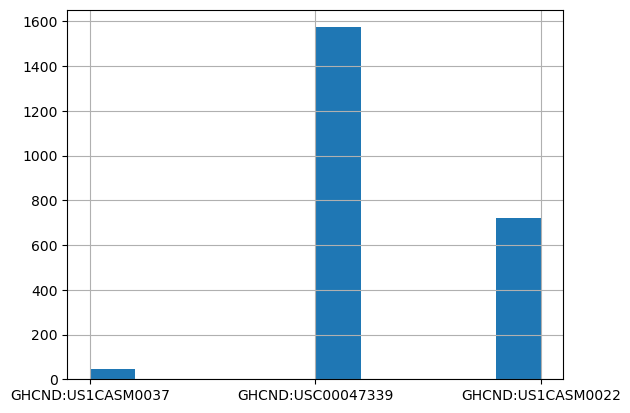

In [236]:
df_weather['station'].hist()

In [237]:
df_weather_wide = df_weather.loc[df_weather['station'] == 'GHCND:USC00047339'].pivot(columns='datatype', index='date', values=[ 'value'])
df_weather_wide.head()

value                    
datatype             PRCP   TMAX  TMIN   TOBS
date                                         
2021-01-01T00:00:00   0.0  156.0  22.0   83.0
2021-01-02T00:00:00  13.0  122.0  78.0  106.0
2021-01-03T00:00:00   0.0  133.0  78.0  100.0
2021-01-04T00:00:00  56.0  156.0  61.0   67.0
2021-01-05T00:00:00   0.0  133.0  39.0   56.0

In [238]:
df_weather_wide = df_weather.loc[df_weather['station'] == 'GHCND:USC00047339'].pivot_table(values=['value'], index='date', columns='datatype')
df_weather_wide.head()

value                    
datatype             PRCP   TMAX  TMIN   TOBS
date                                         
2021-01-01T00:00:00   0.0  156.0  22.0   83.0
2021-01-02T00:00:00  13.0  122.0  78.0  106.0
2021-01-03T00:00:00   0.0  133.0  78.0  100.0
2021-01-04T00:00:00  56.0  156.0  61.0   67.0
2021-01-05T00:00:00   0.0  133.0  39.0   56.0

In [239]:
df_weather_wide.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396 entries, 2021-01-01T00:00:00 to 2022-01-31T00:00:00
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (value, PRCP)  390 non-null    float64
 1   (value, TMAX)  396 non-null    float64
 2   (value, TMIN)  394 non-null    float64
 3   (value, TOBS)  394 non-null    float64
dtypes: float64(4)
memory usage: 15.5+ KB


In [245]:
df_weather_wide.reset_index(inplace=True)

In [241]:
df_weather_wide.columns = df_weather_wide.columns.get_level_values(1)

In [246]:
df_weather_wide.head()

datatype                 date  PRCP   TMAX  TMIN   TOBS
0         2021-01-01T00:00:00   0.0  156.0  22.0   83.0
1         2021-01-02T00:00:00  13.0  122.0  78.0  106.0
2         2021-01-03T00:00:00   0.0  133.0  78.0  100.0
3         2021-01-04T00:00:00  56.0  156.0  61.0   67.0
4         2021-01-05T00:00:00   0.0  133.0  39.0   56.0

In [250]:
df_weather_wide['date'] = pd.to_datetime(df_weather_wide['date'])

In [251]:
df_weather_wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    396 non-null    datetime64[ns]
 1   PRCP    390 non-null    float64       
 2   TMAX    396 non-null    float64       
 3   TMIN    394 non-null    float64       
 4   TOBS    394 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 15.6 KB


In [256]:
df_weather_wide.set_index('date', inplace=True)

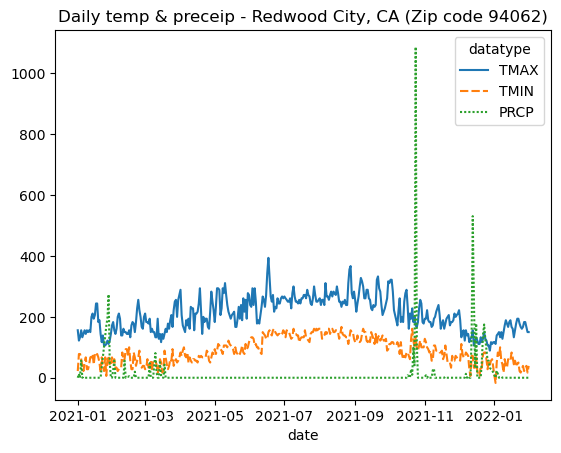

In [257]:
sns.lineplot(data=df_weather_wide[['TMAX', 'TMIN', 'PRCP']])
plt.title('Daily temp & preceip - Redwood City, CA (Zip code 94062)')
plt.show()

In [258]:
df_weather_wide_st2 = df_weather.loc[df_weather['station'] == 'GHCND:US1CASM0022'].pivot(columns='datatype', index='date', values=[ 'value'])
df_weather_wide_st2.head()

value                 
datatype    DAPR   MDPR PRCP SNOW
date                             
2021-01-05   5.0  157.0  NaN  NaN
2021-01-06   NaN    NaN  0.0  0.0
2021-01-07   NaN    NaN  0.0  0.0
2021-01-08   NaN    NaN  8.0  NaN
2021-01-09   NaN    NaN  0.0  0.0

In [212]:
# Fetch Daily Summary data from zip code - Redwood City, CA
dataset = 'data'
params = {'datasetid':'GHCND', 'startdate':'2021-01-01', 'enddate':'2022-01-31', 'locationid':'ZIP:94305', 'limit':'1000'}
r = requests.get(urlbase + dataset, headers=headers, params=params)
r.json()

{}